In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import pymalts as pm
import sklearn.linear_model as lm
import sklearn.svm as svm
import sklearn.ensemble as en
import warnings
warnings.filterwarnings("ignore")

path_to_git = '/Users/harshparikh/Documents/GitHub/iic_causal_inference/'

iic_burden = pd.read_pickle(path_to_git + 'aim1/data_to_fit_CNNIIC_iic_burden_smooth.pickle')

iic_burden.keys()

sns.set(font_scale=3,style='whitegrid')

In [2]:
def plot_unit(E,D,Dnames):
    n_drugs = D.shape[1]
    drug_names = Dnames
    fig,axs = plt.subplots(nrows=1+D.shape[1],ncols=1,
                           sharex=True,
                           figsize=(15, 6 + 1.25*n_drugs),
                           gridspec_kw = {'height_ratios':[4]+[1 for i in range(D.shape[1])]})
    axs[0].plot( E, c='black',label='Observed')
    axs[0].set_title('IIC Burden')
    for i in range(1,1+n_drugs):
        y = D[:,i-1]
        axs[i].imshow(y[np.newaxis,:], cmap="copper", aspect="auto")
        axs[i].set_title(drug_names[i-1])
    

def setup_data(iic_burden,frame=10):
    df = pd.DataFrame(iic_burden['C'],columns=iic_burden['Cname'],index=iic_burden['sids'])
    df['mRS'] = iic_burden['Y']
    n = df.shape[0]
    df_wave = pd.DataFrame()
    for i in (range(n)):
        try:
            E = iic_burden['Pobs'][i][:frame]
            Ename = ['iic_%d'%(j) for j in range(frame)]
            D = iic_burden['D'][i][:frame,:]
            time_of_intervention = np.argmax(D.sum(axis=1)>0)
            if D.sum(axis=1)[time_of_intervention] == 0:
                time_of_intervention = frame-1
            D_flat = D.reshape(-1,)
            Dname_flat = np.array([ ['%s_%d'%(drug,j) for drug in iic_burden['Dname'] ] for j in range(frame) ]).reshape(-1,)
            D_summary = D.sum(axis=0)
            First_D = iic_burden['Dname'][np.argmax(D[time_of_intervention,:])]
            Dname_summary = iic_burden['Dname']
            E_summary_pre = np.nanmean(E[:time_of_intervention])
            E_summary_post = np.nanmean(E[time_of_intervention:])
            if D.sum(axis=1)[time_of_intervention] == 0:
                time_of_intervention = np.inf
                First_D = 0
                E_summary_post = E_summary_pre
            df_temp = pd.DataFrame( [[time_of_intervention]+[First_D]+list(E)+[E_summary_pre,E_summary_post]+list(D_flat)+list(D_summary)], 
                                   index = [df.index[i]],
                                   columns = ['time_of_intervention']+['drug_administered']+Ename+['avg_iic_pre','avg_iic_post']+list(Dname_flat)+list(Dname_summary))
    #         print(df.index[i],df_temp)
            df_wave = df_wave.append(df_temp)
        except:
            continue
    df = df.join(df_wave)
    return df

def setup_coarsen_data(iic_burden,window = 36,summarize='max',**kwargs):
    df = pd.DataFrame(iic_burden['C'],columns=iic_burden['Cname'],index=iic_burden['sids'])
    df['mRS'] = iic_burden['Y']
    n = df.shape[0]
    E_col = []
    D_col = []
    for i in (range(n)):
        t = len(iic_burden['Pobs'][i])
        if t>window:
            if summarize == 'max':
                E = np.max([ np.nanmean(iic_burden['Pobs'][i][j:j+window]) for j in range(t-window) ])
            if summarize == 'proportion':
                threshold = kwargs.get('threshold',0.5)
                E = np.nanmean( np.array([ np.nanmean(iic_burden['Pobs'][i][j:j+window]) for j in range(t-window) ]) > threshold )
            if summarize == 'mean':
                E = np.mean([ np.nanmean(iic_burden['Pobs'][i][j:j+window]) for j in range(t-window) ])
        else:
            E = np.nanmean(iic_burden['Pobs'][i])
        E_col.append(E)
        D = np.nanmean(iic_burden['D'][i],axis=0)
        D_col.append(D)
    df['E'] = E_col
    df_D = pd.DataFrame(D_col,columns=iic_burden['Dname'],index=df.index)
    df = df.join(df_D,how='inner')
    return df
        
        

# Effect of IIC Burden on Outcome

In [3]:
df_coarsen = setup_coarsen_data(iic_burden,window = 6,summarize='mean')
df_pkpd = pd.read_csv('../aim1/step6_simulator/results_iic_burden_smooth/params_mean_CNNIIC_iic_burden_smooth_cauchy_expit_lognormal_drugoutside_ARMA2,6_iter1000.csv',
                     index_col=0, header=0)
df_pkpd = df_pkpd[['alpha0', 'alpha[1]','alpha[2]', 'b[lacosamide]', 'b[levetiracetam]',
                   'b[midazolam]', 'b[pentobarbital]', 'b[phenobarbital]', 'b[propofol]','b[valproate]']].fillna(0)
df_coarsen_1 = df_coarsen[['Gender', 'Age', 'marrital',
                           'Hx CVA (including TIA)', 'Hx HTN', 'Hx Sz /epilepsy', 
                           'Hx brain surgery', 'Hx CKD', 'Hx CAD/MI', 'Hx CHF',
                           'Hx DM', 'Hx of HLD', 'Hx tobacco (including ex-smokers)', 
                           'Hx ETOH abuse any time in their life (just when in the hx is mentioned)', 
                           'Hx other substance abuse, any time in their life', 'Hx cancer (other than CNS cancer)',
                           'Hx CNS cancer', 'Hx COPD/ Asthma', 
                           'premorbid MRS before admission  (modified ranking scale),before admission', 
                           'hydrocephalus  (either on admission or during hospital course)   QPID', 
                           'iMV  (initial (on admission) mechanical ventilation)',
                           'Primary systemic dx Sepsis/Shock', 'Worst GCS in 1st 24',
                           'neuro_dx_Seizures/status epilepticus', 'prim_dx_Respiratory disorders',  
                           'mRS', 'E'
                           ,'lacosamide', 'levetiracetam', 'midazolam', 'pentobarbital', 'phenobarbital', 'propofol', 'valproate']].dropna()

df_coarsen_1 = df_coarsen_1.join(df_pkpd,how='inner')
discrete = ['Gender', 'marrital','Hx CVA (including TIA)', 'Hx HTN', 'Hx Sz /epilepsy', 
            'Hx brain surgery', 'Hx CKD', 'Hx CAD/MI', 'Hx CHF',
            'Hx DM', 'Hx of HLD', 'Hx tobacco (including ex-smokers)', 
            'Hx ETOH abuse any time in their life (just when in the hx is mentioned)', 
            'Hx other substance abuse, any time in their life', 'Hx cancer (other than CNS cancer)',
            'Hx CNS cancer', 'Hx COPD/ Asthma', 
            'premorbid MRS before admission  (modified ranking scale),before admission', 
            'hydrocephalus  (either on admission or during hospital course)   QPID', 
            'iMV  (initial (on admission) mechanical ventilation)',
            'Primary systemic dx Sepsis/Shock',
            'neuro_dx_Seizures/status epilepticus', 'prim_dx_Respiratory disorders']

df_coarsen_1['Y'] = (df_coarsen_1['mRS'] > 3).astype(float)

n_thresholds = 5
thresholds = [0,0.25,0.5,0.75,1]#list(np.linspace(0,1,num=n_thresholds))
gain = thresholds[1]-thresholds[0]
iic_level = df_coarsen_1['E']>2
for threshold in thresholds:
    iic_level = iic_level + gain*(df_coarsen_1['E']>threshold).astype(int)
    
iic_level = iic_level - (gain/2) * ((iic_level - (gain/2)) > 0)
drug_level = ( (df_coarsen_1['levetiracetam'] > 20) + 
              (df_coarsen_1['propofol']>1) + 
              (df_coarsen_1['midazolam']>0) +
              (df_coarsen_1['lacosamide']>0) +
              (df_coarsen_1['pentobarbital']>0) +
              (df_coarsen_1['phenobarbital']>0) +
              (df_coarsen_1['valproate']>0) ).astype(int)

df_coarsen_1['iic'] = np.round(iic_level,2).astype(str)
df_coarsen_1['drug'] = drug_level
df_coarsen_1['T'] = '('+df_coarsen_1['iic'].astype(str) +', '+df_coarsen_1['drug'].astype(str)+')'

In [4]:
thresholds

[0, 0.25, 0.5, 0.75, 1]

<AxesSubplot:ylabel='Frequency'>

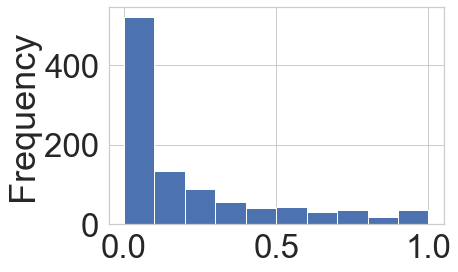

In [5]:
df_coarsen_1['E'].plot(kind='hist')

In [6]:
df_coarsen_1.groupby(by='T').mean()

,Gender,Age,marrital,Hx CVA (including TIA),Hx HTN,Hx Sz /epilepsy,Hx brain surgery,Hx CKD,Hx CAD/MI,Hx CHF,...,alpha[2],b[lacosamide],b[levetiracetam],b[midazolam],b[pentobarbital],b[phenobarbital],b[propofol],b[valproate],Y,drug
T,,,,,,,,,,,,,,,,,,,,,
"(0.0, 0)",0.888889,50.561111,0.444444,0.222222,0.555556,0.111111,0.000000,0.111111,0.222222,0.111111,...,0.173804,0.000000,0.000000,0.000000,0.000000,0.000000,2.543090,0.000000,0.888889,0
"(0.0, 1)",0.730769,57.662692,0.423077,0.230769,0.576923,0.192308,0.000000,0.153846,0.307692,0.192308,...,0.188547,0.351080,4.562006,3.100338,0.000000,0.060002,18.481702,0.000000,0.692308,1
"(0.12, 0)",0.463918,60.070515,0.530928,0.201031,0.515464,0.190722,0.139175,0.118557,0.144330,0.087629,...,0.205215,0.000000,0.526139,0.000000,0.000000,0.000000,0.706445,0.000000,0.654639,0
"(0.12, 1)",0.489451,59.123650,0.472574,0.179325,0.506329,0.158228,0.078059,0.097046,0.158228,0.069620,...,0.162815,1.086128,2.969058,2.838745,0.206167,0.468040,8.325046,0.534534,0.803797,1
"(0.38, 0)",0.472222,56.466667,0.444444,0.222222,0.611111,0.361111,0.222222,0.111111,0.194444,0.027778,...,0.228984,0.000000,0.175569,0.000000,0.000000,0.000000,0.169815,0.000000,0.666667,0
"(0.38, 1)",0.431373,58.906765,0.519608,0.156863,0.558824,0.098039,0.058824,0.137255,0.166667,0.098039,...,0.244315,0.000247,0.834499,1.624021,0.000380,0.067018,1.352150,0.011048,0.892157,1
"(0.62, 0)",0.440000,61.194000,0.640000,0.280000,0.720000,0.440000,0.200000,0.240000,0.200000,0.160000,...,0.270927,0.000000,0.048584,0.000000,0.000000,0.000000,0.907051,0.000000,0.800000,0
"(0.62, 1)",0.412698,61.514444,0.492063,0.238095,0.507937,0.174603,0.158730,0.111111,0.111111,0.158730,...,0.180922,0.150940,1.172712,2.316513,0.062245,0.015598,2.830891,0.043498,0.952381,1
"(0.88, 0)",0.363636,63.906818,0.681818,0.181818,0.772727,0.272727,0.318182,0.181818,0.318182,0.181818,...,0.283662,0.000000,0.845217,0.000000,0.000000,0.000000,0.000000,0.000000,0.818182,0


## Controlling for age

In [7]:
n_repeats = 5
n_splits = 3
df_malts_data = df_coarsen_1[['Age','Y','T']]
discrete = []
m = pm.malts_mf(outcome='Y',
                treatment='T', 
                data=df_malts_data,
                n_repeats=n_repeats,
                n_splits=n_splits,
                output_format='full',
                k_tr=2,
                k_est=2,
                discrete = discrete,
                C=0.01)

In [8]:
list(m.CATE_df.columns.unique())

['Y((0.62, 1))',
 'Y((0.12, 1))',
 'Y((0.12, 0))',
 'Y((0.88, 1))',
 'Y((0.88, 0))',
 'Y((0.62, 0))',
 'Y((0.38, 1))',
 'Y((0.38, 0))',
 'Y((0.0, 0))',
 'Y((0.0, 1))',
 'diameter((0.62, 1))',
 'diameter((0.12, 1))',
 'diameter((0.12, 0))',
 'diameter((0.88, 1))',
 'diameter((0.88, 0))',
 'diameter((0.62, 0))',
 'diameter((0.38, 1))',
 'diameter((0.38, 0))',
 'diameter((0.0, 0))',
 'diameter((0.0, 1))',
 'Y',
 'T']

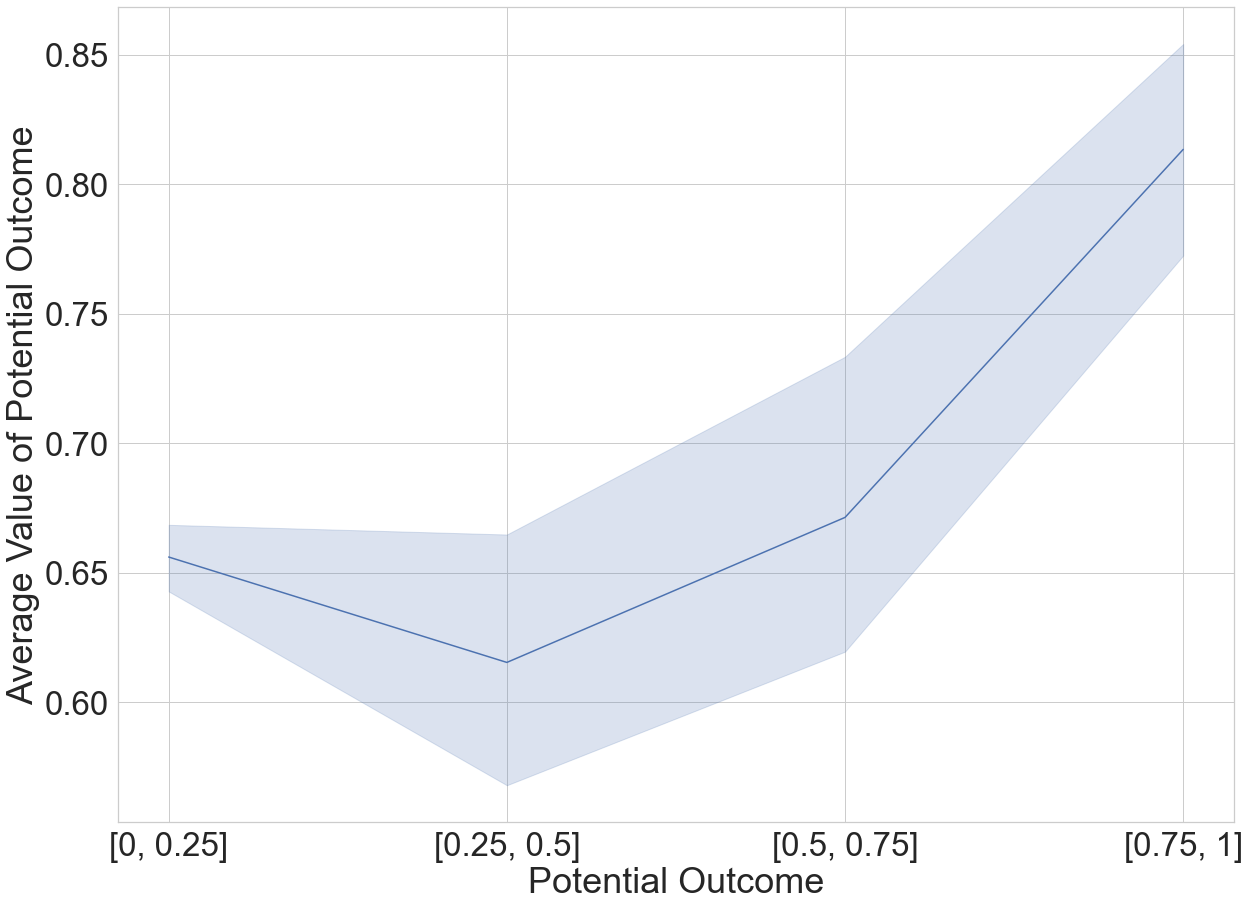

In [9]:
out = m.CATE_df.drop(columns = ['Y','T'])#.T.groupby(level=0).mean().T
out.to_csv('new_mean_age.csv')
columns = ['Y(('+str(np.round(threshold-gain/2,2))+', 0))' for threshold in thresholds[1:]]
apo_0 = out[columns]
columns = ['Y(('+str(np.round(threshold-gain/2,2))+', 1))' for threshold in thresholds[1:]]
apo_1 = out[columns]
columns = ['diameter(('+str(np.round(threshold-gain/2,2))+', 0))' for threshold in thresholds[1:]]
diam_0 = out[columns]
columns = ['diameter(('+str(np.round(threshold-gain/2,2))+', 1))' for threshold in thresholds[1:]]
diam_1 = out[columns]

apo_tight_0 = pd.DataFrame(apo_0.values*(diam_0<1).astype(int).replace(0, np.nan).values,
                         index=apo_0.index,columns=apo_0.columns)
apo_tight_0.mean(axis=0)

apo_tight_1 = pd.DataFrame(apo_1.values*(diam_1<1).astype(int).replace(0, np.nan).values,
                         index=apo_1.index,columns=apo_0.columns)
apo_tight_1.mean(axis=0)

fig,ax = plt.subplots(figsize=(20,15))
sns.lineplot(data=apo_tight_0.mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'}),
            x='index',y='Average Potential Outcome',ax=ax)
plt.xlabel('Potential Outcome')
plt.ylabel('Average Value of Potential Outcome')
plt.xticks(np.arange(len(thresholds)-1),[str([thresholds[i-1],thresholds[i]]) for i in range(1,len(thresholds)) ] )
fig.savefig('new_mean_age.png')

In [10]:
['Y((%f, 0))'%(threshold-gain/2) for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]

['Y((0.125000, 0))',
 'Y((0.375000, 0))',
 'Y((0.625000, 0))',
 'Y((0.875000, 0))']

## Controlling for All Preadmission Covariates

In [24]:
n_repeats = 5
n_splits = 3
df_malts_data = df_coarsen_1[['Gender', 'Age', 'marrital',
                           'Hx CVA (including TIA)', 'Hx HTN', 'Hx Sz /epilepsy', 
                           'Hx brain surgery', 'Hx CKD', 'Hx CAD/MI', 'Hx CHF',
                           'Hx DM', 'Hx of HLD', 'Hx tobacco (including ex-smokers)', 
                           'Hx ETOH abuse any time in their life (just when in the hx is mentioned)', 
                           'Hx other substance abuse, any time in their life', 'Hx cancer (other than CNS cancer)',
                           'Hx CNS cancer', 'Hx COPD/ Asthma', 
                           'premorbid MRS before admission  (modified ranking scale),before admission', 
                           'hydrocephalus  (either on admission or during hospital course)   QPID', 
                           'iMV  (initial (on admission) mechanical ventilation)',
                           'Primary systemic dx Sepsis/Shock', 'Worst GCS in 1st 24',
                           'neuro_dx_Seizures/status epilepticus', 'prim_dx_Respiratory disorders','Y','T']]
discrete = ['Gender', 'marrital','Hx CVA (including TIA)', 'Hx HTN', 'Hx Sz /epilepsy', 
            'Hx brain surgery', 'Hx CKD', 'Hx CAD/MI', 'Hx CHF',
            'Hx DM', 'Hx of HLD', 'Hx tobacco (including ex-smokers)', 
            'Hx ETOH abuse any time in their life (just when in the hx is mentioned)', 
            'Hx other substance abuse, any time in their life', 'Hx cancer (other than CNS cancer)',
            'Hx CNS cancer', 'Hx COPD/ Asthma', 
            'premorbid MRS before admission  (modified ranking scale),before admission', 
            'hydrocephalus  (either on admission or during hospital course)   QPID', 
            'iMV  (initial (on admission) mechanical ventilation)',
            'Primary systemic dx Sepsis/Shock',
            'neuro_dx_Seizures/status epilepticus', 'prim_dx_Respiratory disorders']
m = pm.malts_mf(outcome='Y',
                treatment='T', 
                data=df_malts_data,
                n_repeats=n_repeats,
                n_splits=n_splits,
                output_format='full',
                k_tr=2,
                k_est=4,
                discrete = discrete,
                C=0.01)

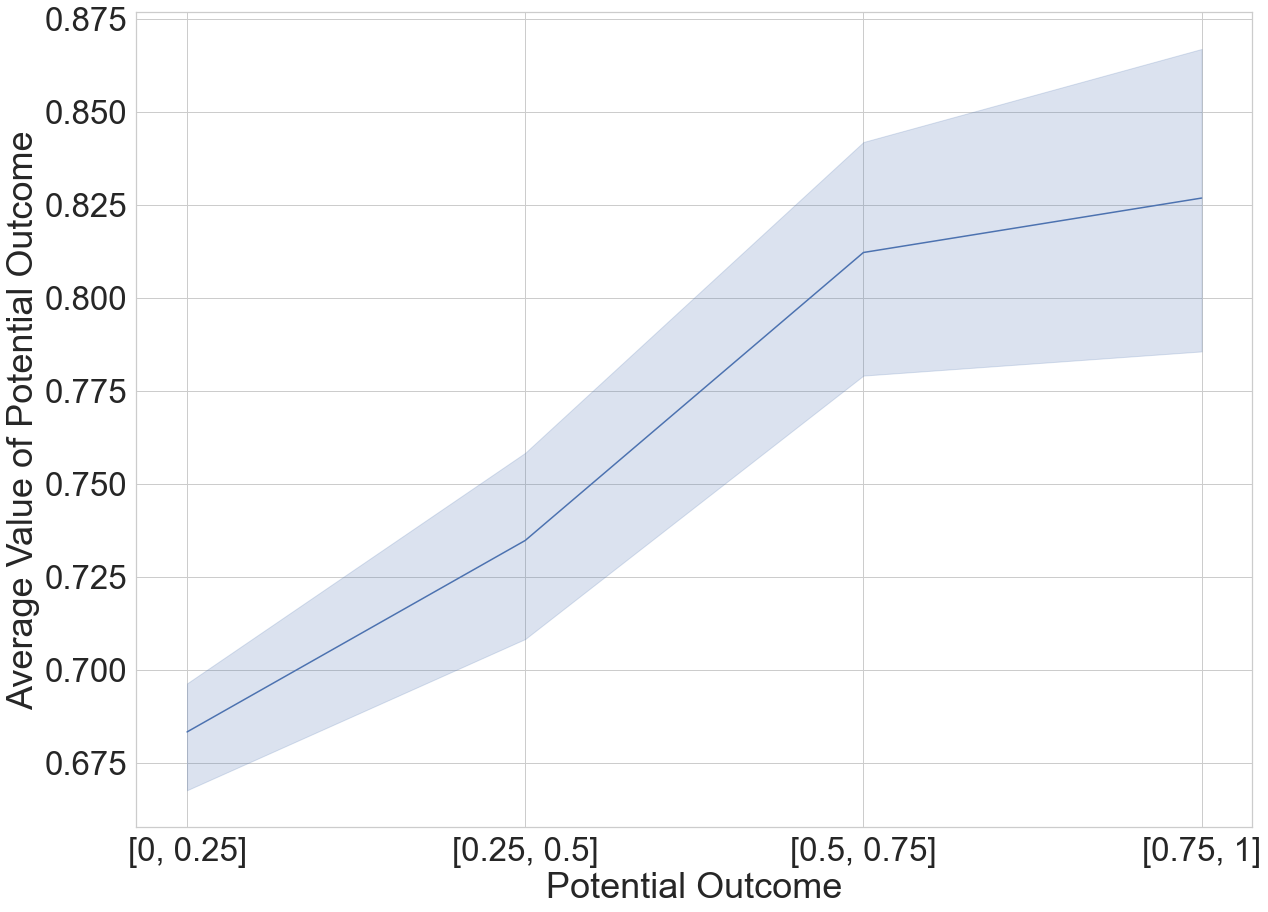

In [25]:
out_c = m.CATE_df.drop(columns = ['Y','T'])#.T.groupby(level=0).mean().T
out_c.to_csv('new_mean_c.csv')
columns = ['Y(('+str(np.round(threshold-gain/2,2))+', 0))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]
apo_0_c = out_c[columns]
columns = ['Y(('+str(np.round(threshold-gain/2,2))+', 1))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]
apo_1_c = out_c[columns]
columns = ['diameter(('+str(np.round(threshold-gain/2,2))+', 0))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]
diam_0_c = out_c[columns]
columns = ['diameter(('+str(np.round(threshold-gain/2,2))+', 1))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]
diam_1_c = out_c[columns]

apo_tight_0_c = pd.DataFrame(apo_0_c.values*(diam_0_c<5).astype(int).replace(0, np.nan).values,
                         index=apo_0_c.index,columns=apo_0_c.columns)
apo_tight_0_c.mean(axis=0)

apo_tight_1_c = pd.DataFrame(apo_1_c.values*(diam_1_c<0.5).astype(int).replace(0, np.nan).values,
                         index=apo_1_c.index,columns=apo_0_c.columns)
apo_tight_1_c.mean(axis=0)

fig,ax = plt.subplots(figsize=(20,15))
sns.lineplot(data=apo_tight_0_c.mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'}),
            x='index',y='Average Potential Outcome',ax=ax)
plt.xlabel('Potential Outcome')
plt.ylabel('Average Value of Potential Outcome')
plt.xticks(np.arange(len(thresholds)-1),[str([thresholds[i-1],thresholds[i]]) for i in range(1,len(thresholds)) ] )
fig.savefig('new_mean_c.png')

# Controlling for all pre-admission covariates and PKPD parameters

In [13]:
n_repeats = 10
n_splits = 3
df_malts_data = df_coarsen_1[['b[lacosamide]', 'b[levetiracetam]',
                            'b[midazolam]', 'b[pentobarbital]', 'b[phenobarbital]', 
                            'b[propofol]','b[valproate]',
                            'Gender', 'Age', 'marrital',
                           'Hx CVA (including TIA)', 'Hx HTN', 'Hx Sz /epilepsy', 
                           'Hx brain surgery', 'Hx CKD', 'Hx CAD/MI', 'Hx CHF',
                           'Hx DM', 'Hx of HLD', 'Hx tobacco (including ex-smokers)', 
                           'Hx ETOH abuse any time in their life (just when in the hx is mentioned)', 
                           'Hx other substance abuse, any time in their life', 'Hx cancer (other than CNS cancer)',
                           'Hx CNS cancer', 'Hx COPD/ Asthma', 
                           'premorbid MRS before admission  (modified ranking scale),before admission', 
                           'hydrocephalus  (either on admission or during hospital course)   QPID', 
                           'iMV  (initial (on admission) mechanical ventilation)',
                           'Primary systemic dx Sepsis/Shock', 'Worst GCS in 1st 24',
                           'neuro_dx_Seizures/status epilepticus', 'prim_dx_Respiratory disorders','Y','T']]
discrete = ['Gender', 'marrital','Hx CVA (including TIA)', 'Hx HTN', 'Hx Sz /epilepsy', 
            'Hx brain surgery', 'Hx CKD', 'Hx CAD/MI', 'Hx CHF',
            'Hx DM', 'Hx of HLD', 'Hx tobacco (including ex-smokers)', 
            'Hx ETOH abuse any time in their life (just when in the hx is mentioned)', 
            'Hx other substance abuse, any time in their life', 'Hx cancer (other than CNS cancer)',
            'Hx CNS cancer', 'Hx COPD/ Asthma', 
            'premorbid MRS before admission  (modified ranking scale),before admission', 
            'hydrocephalus  (either on admission or during hospital course)   QPID', 
            'iMV  (initial (on admission) mechanical ventilation)',
            'Primary systemic dx Sepsis/Shock',
            'neuro_dx_Seizures/status epilepticus', 'prim_dx_Respiratory disorders']
m = pm.malts_mf(outcome='Y',
                treatment='T', 
                data=df_malts_data,
                n_repeats=n_repeats,
                n_splits=n_splits,
                output_format='full',
                k_tr=3,
                k_est=5,
                discrete = discrete,
                C=0.01)

b[levetiracetam]                                                             0.154940
b[lacosamide]                                                                0.115301
Worst GCS in 1st 24                                                          0.103918
Hx other substance abuse, any time in their life                             0.070591
marrital                                                                     0.086354
Hx CVA (including TIA)                                                       0.067293
Hx cancer (other than CNS cancer)                                            0.074846
b[midazolam]                                                                 0.078324
Hx of HLD                                                                    0.053802
b[phenobarbital]                                                             0.087447
b[propofol]                                                                  0.077207
Hx COPD/ Asthma                                       

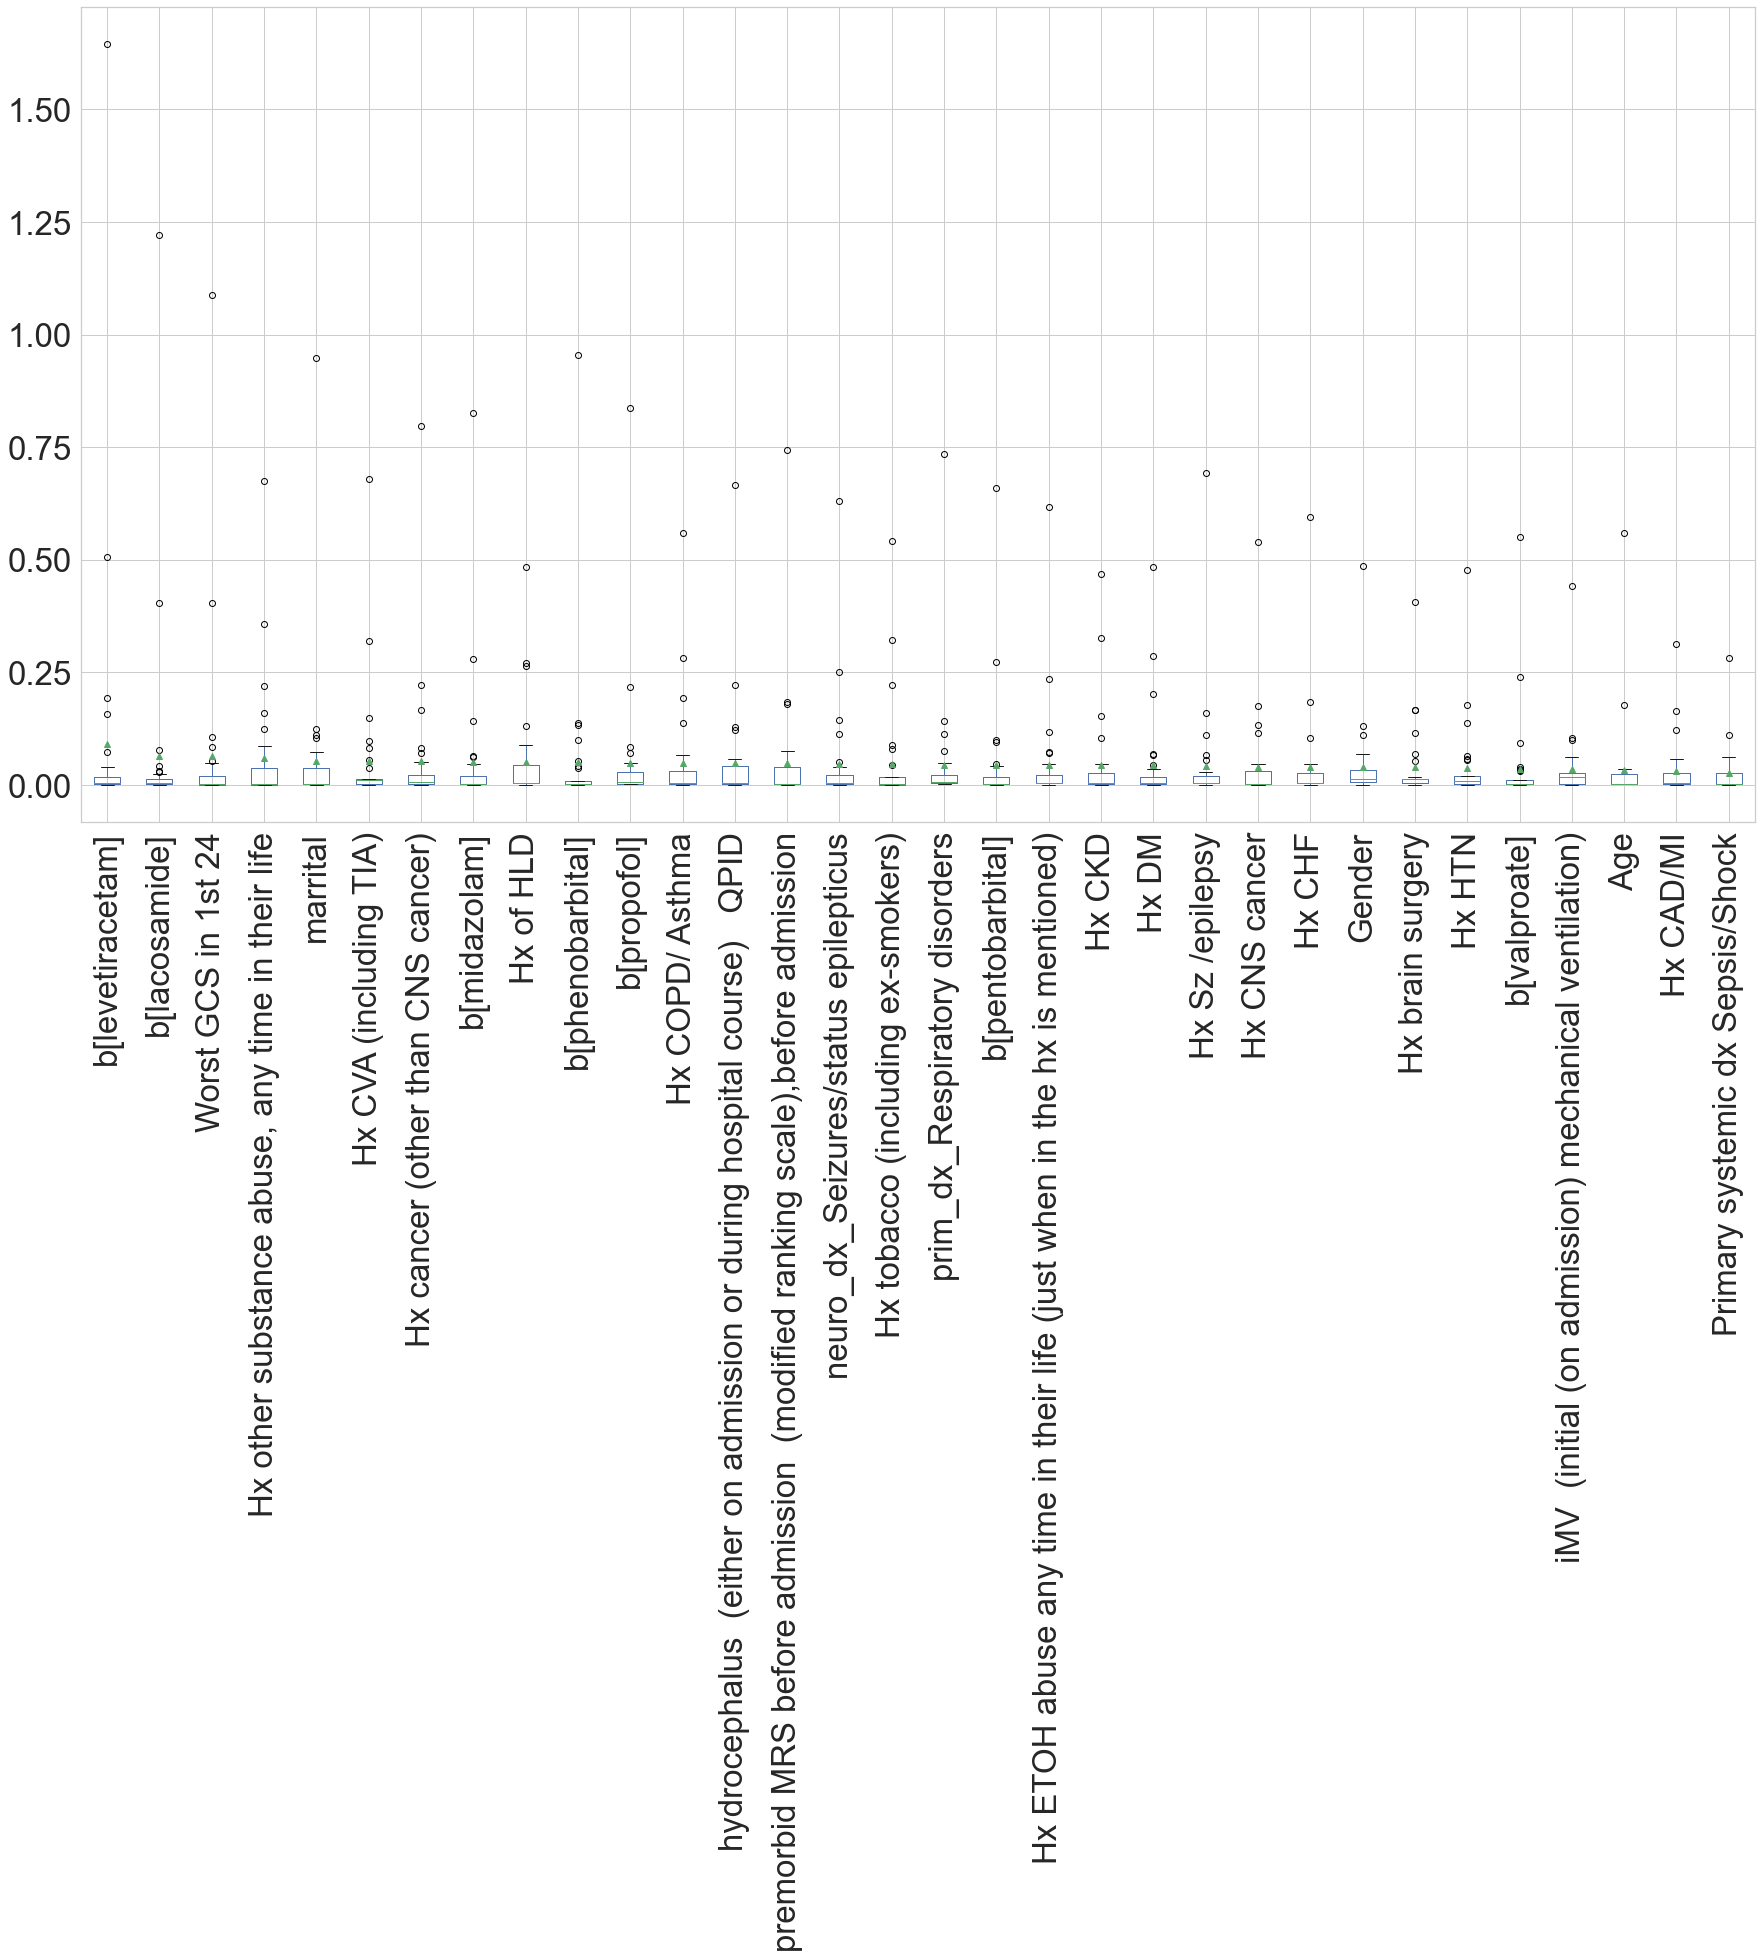

In [14]:
fig,ax = plt.subplots(figsize=(30,15))
columns_order = list(pd.concat(m.M_opt_list).mean(axis=0).sort_values(ascending=False).index)
pd.concat(m.M_opt_list)[columns_order].plot(kind='box',ax=ax,rot=90,showmeans=True)
pd.concat(m.M_opt_list)[columns_order].std(axis=0)/2
# plt.ylim(-0.001,1.0)

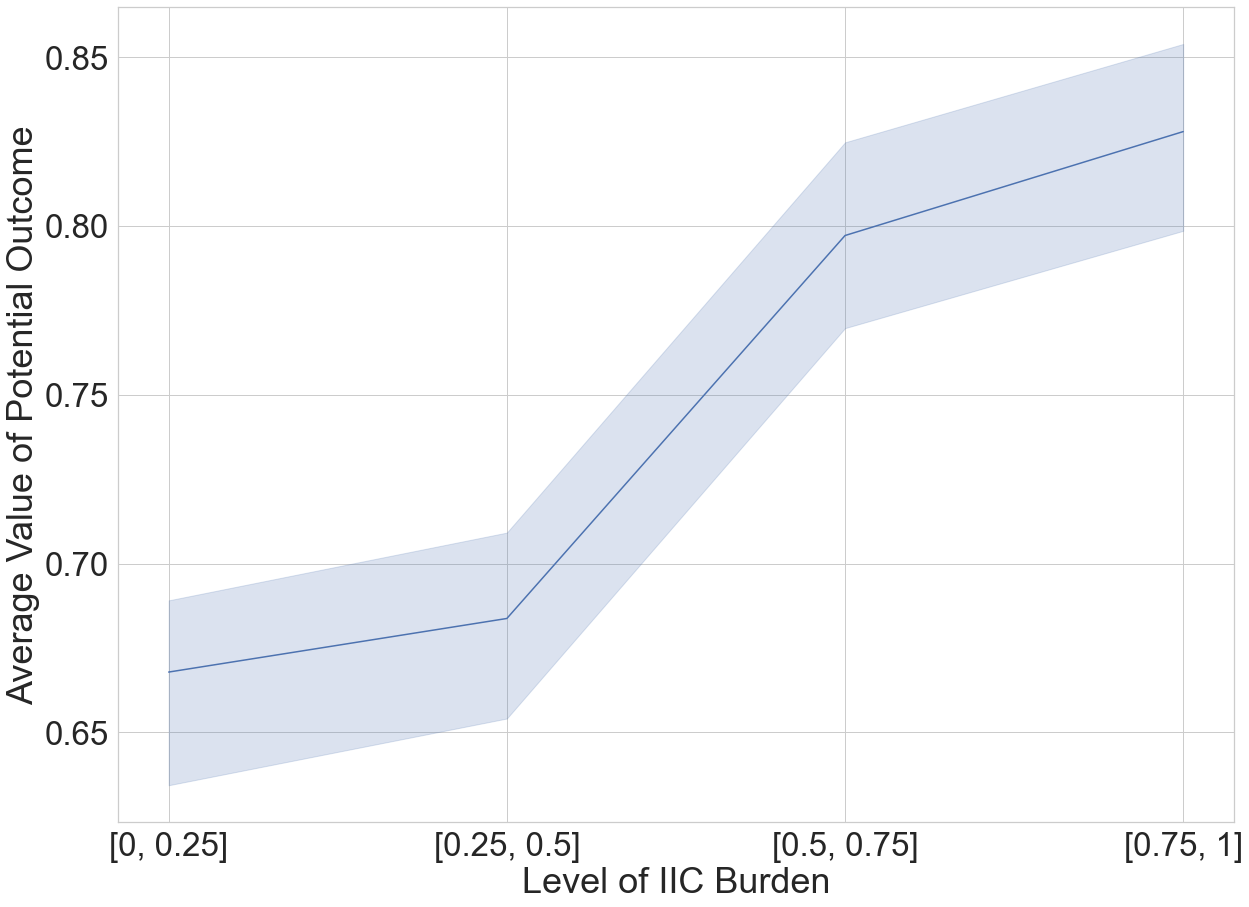

In [23]:
out = m.CATE_df.drop(columns = ['Y','T'])#.T.groupby(level=0).mean().T
out.to_csv('new_mean_c_pkpd.csv')
columns = ['Y(('+str(np.round(threshold-gain/2,2))+', 0))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]
apo_0_c_pkpd = out[columns]
columns = ['Y(('+str(np.round(threshold-gain/2,2))+', 1))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]
apo_1_c_pkpd = out[columns]
columns = ['diameter(('+str(np.round(threshold-gain/2,2))+', 0))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]
diam_0_c_pkpd = out[columns]
columns = ['diameter(('+str(np.round(threshold-gain/2,2))+', 1))' for threshold in np.linspace(thresholds[1],1,num=n_thresholds-1)]
diam_1_c_pkpd = out[columns]

apo_tight_0_c_pkpd = pd.DataFrame(apo_0_c_pkpd.values*(diam_0_c_pkpd<5).astype(int).replace(0, np.nan).values,
                         index=apo_0_c_pkpd.index,columns=apo_0_c_pkpd.columns)
apo_tight_0_c_pkpd.mean(axis=0)

apo_tight_1_c_pkpd = pd.DataFrame(apo_1_c_pkpd.values*(diam_1_c_pkpd<0.2).astype(int).replace(0, np.nan).values,
                         index=apo_1_c_pkpd.index,columns=apo_0_c_pkpd.columns)
apo_tight_1_c_pkpd.mean(axis=0)

fig,ax = plt.subplots(figsize=(20,15))
sns.lineplot(data=apo_tight_0_c_pkpd.mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'}),
            x='index',y='Average Potential Outcome',ax=ax)
# sns.lineplot(data=apo_tight_1_c_pkpd.mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'}),
#             x='index',y='Average Potential Outcome',ax=ax,ci='sd')
plt.xlabel('Level of IIC Burden')
plt.ylabel('Average Value of Potential Outcome')
plt.xticks(np.arange(len(thresholds)-1),[str([thresholds[i-1],thresholds[i]]) for i in range(1,len(thresholds)) ] )
fig.savefig('new_mean_c_pkpd.png')

In [29]:
print(apo_tight_0_c_pkpd.mean(axis=0).dropna().to_string())

Y((0.12, 0))    0.669151
Y((0.12, 0))    0.717735
Y((0.12, 0))    0.658631
Y((0.12, 0))    0.670343
Y((0.12, 0))    0.685544
Y((0.12, 0))    0.683465
Y((0.12, 0))    0.671987
Y((0.12, 0))    0.718033
Y((0.12, 0))    0.700627
Y((0.12, 0))    0.688525
Y((0.12, 0))    0.689717
Y((0.12, 0))    0.677039
Y((0.12, 0))    0.697466
Y((0.12, 0))    0.673920
Y((0.12, 0))    0.676508
Y((0.12, 0))    0.638450
Y((0.12, 0))    0.685544
Y((0.12, 0))    0.305556
Y((0.12, 0))    0.712966
Y((0.12, 0))    0.630700
Y((0.12, 0))    0.710417
Y((0.12, 0))    0.680477
Y((0.12, 0))    0.674814
Y((0.12, 0))    0.640774
Y((0.12, 0))    0.582385
Y((0.12, 0))    0.718425
Y((0.12, 0))    0.681250
Y((0.12, 0))    0.646796
Y((0.12, 0))    0.757143
Y((0.12, 0))    0.690882
Y((0.38, 0))    0.663189
Y((0.38, 0))    0.690909
Y((0.38, 0))    0.720536
Y((0.38, 0))    0.732340
Y((0.38, 0))    0.675708
Y((0.38, 0))    0.503333
Y((0.38, 0))    0.764495
Y((0.38, 0))    0.630402
Y((0.38, 0))    0.756289
Y((0.38, 0))    0.753800


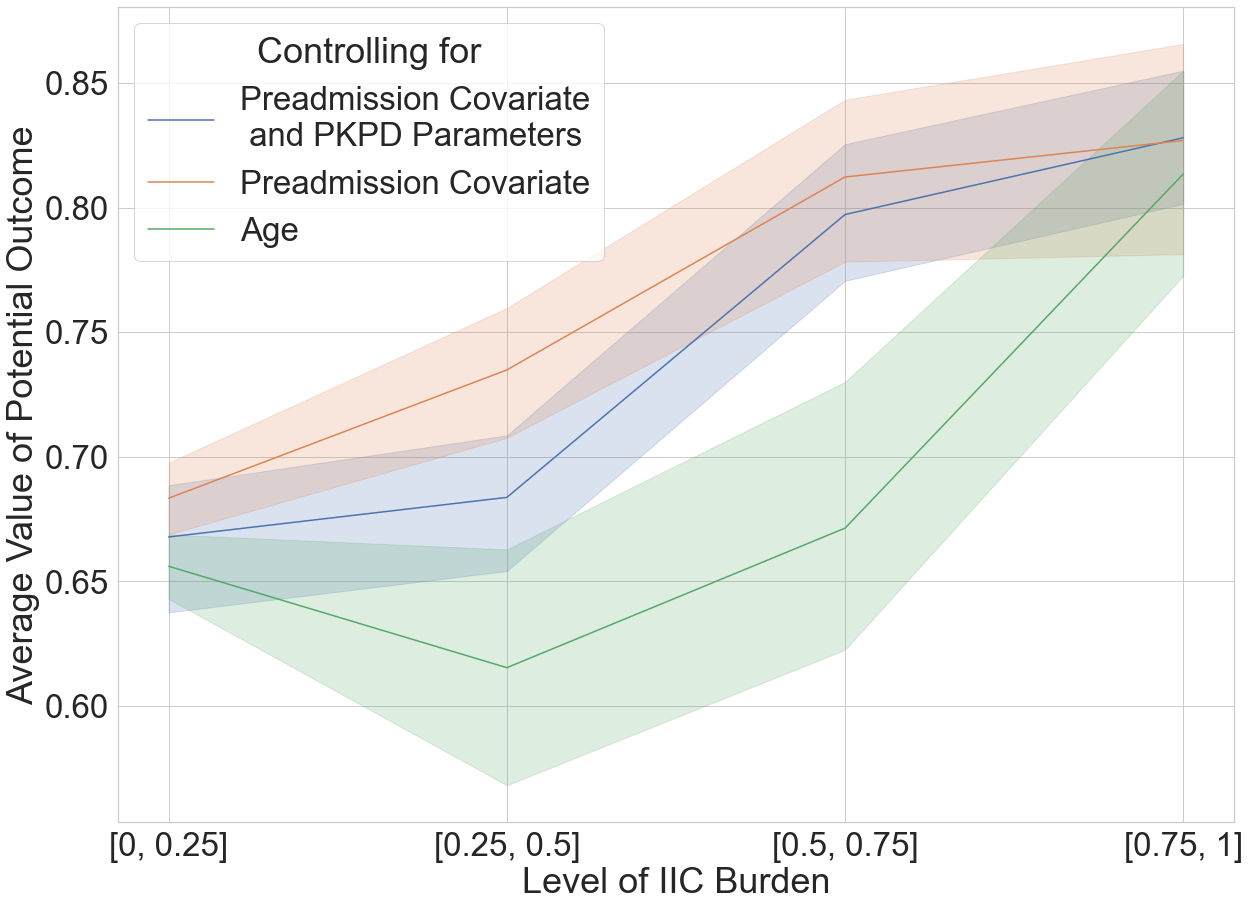

In [26]:
fig,ax = plt.subplots(figsize=(20,15))
sns.lineplot(data=apo_tight_0_c_pkpd.mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'}),
            x='index',y='Average Potential Outcome',ax=ax)
sns.lineplot(data=apo_tight_0_c.mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'}),
            x='index',y='Average Potential Outcome',ax=ax)
sns.lineplot(data=apo_tight_0.mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'}),
            x='index',y='Average Potential Outcome',ax=ax)
# sns.lineplot(data=apo_tight_1_c_pkpd.mean(axis=0).reset_index().rename(columns={0:'Average Potential Outcome'}),
#             x='index',y='Average Potential Outcome',ax=ax,ci='sd')
plt.legend(['Preadmission Covariate\n and PKPD Parameters','Preadmission Covariate','Age'],title="Controlling for")
plt.xlabel('Level of IIC Burden')
plt.ylabel('Average Value of Potential Outcome')
plt.xticks(np.arange(len(thresholds)-1),[str([thresholds[i-1],thresholds[i]]) for i in range(1,len(thresholds)) ] )
fig.savefig('new_max.png')

In [ ]:
df_m_atec_dict = {}
for type_summary in m_dict_dict.keys():
    m_dict = m_dict_dict[type_summary]
    df_dict = df_dict_dict[type_summary]
    cutoff = {threshold: pd.concat(m_dict[threshold].M_opt_list).mean(axis=0).sum() for threshold in m_dict.keys()}
    df_m_atec = pd.DataFrame( np.array([ m_dict[threshold].CATE_df.loc[(df_dict[threshold]['levetiracetam'] <= 0) 
                                                                       & (df_dict[threshold]['propofol']<=1) 
                                                                       & (df_dict[threshold]['midazolam']<=0.1)
                                                                       & (df_dict[threshold]['lacosamide']<=0)
                                                                       & (df_dict[threshold]['pentobarbital']<=0)
                                                                       & (df_dict[threshold]['phenobarbital']<=0)
                                                                       & (df_dict[threshold]['valproate']<=0)
                                                                       & (m_dict[threshold].CATE_df['avg.Diameter'] <= 3*cutoff[threshold])
#                                                                        & (m_dict[threshold].CATE_df['T'] == 1)
                                                                      ].mean(axis=0)['CATE'].values for threshold in m_dict.keys()]), 
                            index = ['(%.2f,%.2f]'%(thresholds[j],thresholds[j+1]) for j in range(len(m_dict.keys()))], columns = ['ATE' for i in range(len(m_dict[threshold].CATE_df.mean(axis=0)['CATE'].values))] )
    df_m_atec_dict[type_summary] = df_m_atec

In [ ]:
for type_summary in df_m_atec_dict.keys():
    df_m_atec = df_m_atec_dict[type_summary]
    df_m_atec.to_csv('df_m_atec_'+type_summary+'_c_pkpd.csv')

In [ ]:
for type_summary in m_dict_dict.keys():
    fig,ax = plt.subplots(figsize=(16,14))
    df_m_atec_dict[type_summary].T.plot(kind='box',showmeans=True,
                                        ax=ax,
                                        patch_artist=True,
#                                         meanline=True,
                                        capprops={'alpha':0.6,'lw':5},
                                        whiskerprops = {'alpha':0.6,'lw':5},
                                        boxprops={'alpha':0.6,'lw':5},
                                        medianprops={'lw':4,'color':'black','ls':'--'},
                                        meanprops={'markersize':15,'markerfacecolor':'black'})
    plt.axhline(0,c='red',lw=5)
    plt.ylabel('$\\mathbb{E}(Y(E_{%s} \\in threshold, \\bar{0}) - Y(E_{%s} \\in [0.0,0.1],\\bar{0}))$'%(type_summary,type_summary))
    plt.xlabel('$threshold$')
    plt.title('%s'%(type_summary))
    fig.savefig(type_summary+'_c_pkpd.png')

In [ ]:
df_m_atec_dict['max']

In [ ]:
for type_summary in ['max','mean']:
    fig,ax = plt.subplots(figsize=(20,16))
    df_m_atec = df_m_atec_dict[type_summary]
#     for control_var in ['c_pkpd']:
#         df_m_atec =  pd.read_csv('df_m_atec_'+type_summary+'_'+control_var+'.csv').rename(columns={'Unnamed: 0':'index'})
    levels = list(df_m_atec.reset_index()['index'])
    df = pd.DataFrame(df_m_atec.reset_index().drop(columns=['index']).stack(level=0).droplevel(1),columns=['ATE'])
    df['Level'] = df.index
    sns.lineplot(x='Level',y='ATE',data=df,ci='sd')
    plt.xlim((0,2))
#     plt.legend(['Age','All Preadmission Covariates','All Preadmission Covariates \nand PKPD Parameters'],title="Controlling for")
    plt.xticks(np.arange(len(levels)),levels,rotation=90)
    plt.axhline(0,c='red',lw=5)
    plt.ylabel('Estimated Causal Effect')
               # \n$\\mathbb{E}(Y(E_{%s} \\in threshold, \\bar{0}) - Y(E_{%s} \\in [0.0,0.1],\\bar{0}))$'%(type_summary,type_summary)
    plt.xlabel('IIC Burden')
    plt.title('%s'%(type_summary))
#     fig.savefig(type_summary+'_line.png')

In [ ]:
pd.concat(m_dict[threshold].M_opt_list).mean(axis=0).sum()

In [ ]:
df_means

# Heterogeneous Effects

In [ ]:
type_summary = 'max'
threshold = 0.8
df_analysis = df_dict_dict[type_summary][threshold].join(m_dict_dict[type_summary][threshold].CATE_df['avg.CATE']).loc[(df_dict_dict[type_summary][threshold]['levetiracetam'] <= 1) 
                                                                       & (df_dict_dict[type_summary][threshold]['propofol']<=1) 
                                                                       & (df_dict_dict[type_summary][threshold]['midazolam']<=0.1)
                                                                       & (df_dict_dict[type_summary][threshold]['lacosamide']<=0)
                                                                       & (df_dict_dict[type_summary][threshold]['pentobarbital']<=0)
                                                                       & (df_dict_dict[type_summary][threshold]['phenobarbital']<=0)
                                                                       & (df_dict_dict[type_summary][threshold]['valproate']<=0)
                                                                       & (m_dict_dict[type_summary][threshold].CATE_df['avg.Diameter'] <= 2.5*cutoff[threshold])]

In [ ]:
import sklearn.tree as tree

In [ ]:
ex_model = tree.DecisionTreeRegressor(max_leaf_nodes=8,min_samples_leaf=15,min_impurity_decrease=0.0001).fit(df_analysis.drop(columns=['marrital','Y','mRS','E','avg.CATE','alpha0','alpha[1]','alpha[2]']),
                                                            df_analysis['avg.CATE'])
# df_analysis.drop(columns=['marrital','Y','mRS','E','avg.CATE','alpha0','alpha[1]','alpha[2]','premorbid MRS before admission  (modified ranking scale),before admission'])

In [ ]:

fig,ax = plt.subplots(figsize=(20,15))
tree.plot_tree(ex_model,feature_names=df_analysis.drop(columns=['marrital','Y','mRS','E','avg.CATE','alpha0','alpha[1]','alpha[2]']).rename(columns={'premorbid MRS before admission  (modified ranking scale),before admission':'preadmission mRS','iMV  (initial (on admission) mechanical ventilation)':'mechanical ventilation'}).columns,filled=True)

In [ ]:
import sklearn.ensemble as en

In [ ]:
ex_model_ada = en.AdaBoostRegressor(n_estimators=1000).fit(df_analysis.drop(columns=['marrital','Y','mRS','E','avg.CATE','alpha0','alpha[1]','alpha[2]']),
                                                            df_analysis['avg.CATE'])

In [ ]:
df_analysis['avg.CATE']

In [ ]:
age_range = np.arange(18,80)
dumy_x_0 = np.zeros((len(age_range),df_analysis.drop(columns=['marrital','Y','mRS','E','avg.CATE','alpha0','alpha[1]','alpha[2]']).shape[1]))
dumy_x_1 = np.ones((len(age_range),df_analysis.drop(columns=['marrital','Y','mRS','E','avg.CATE','alpha0','alpha[1]','alpha[2]']).shape[1]))
dumy_x_0[:,1] = age_range
dumy_x_1[:,1] = age_range
acc_res_0 = 0
acc_res_1 = 0
counter = 0
for estimator in ex_model_ada.estimators_:
    if estimator.feature_importances_[1]>0:
        acc_res_0 += estimator.predict(dumy_x_0)
        acc_res_1 += estimator.predict(dumy_x_1)
        counter += 1
acc_res_0 = acc_res_0/counter
acc_res_1 = acc_res_1/counter

In [ ]:
sns.regplot(age_range,acc_res_0,order=4,scatter=False)
sns.regplot(age_range,acc_res_1,order=4,scatter=False)

In [ ]:
for type_summary in m_dict_dict.keys():
    for threshold in m_dict_dict[type_summary].keys():
        m_dict_dict[type_summary][threshold].CATE_df.to_csv('CATES_%s_%.0f.csv'%(type_summary,threshold*10))
        m_dict_dict[type_summary][threshold].MG_matrix.to_csv('MG_%s_%.0f.csv'%(type_summary,threshold*10))
        df_dict_dict[type_summary][threshold].to_csv('df_malts_estimation_set_%s_%.0f.csv'%(type_summary,threshold*10))
    df_means_dict[type_summary].to_csv('descriptive_summary_estimation_set_%s.csv'%(type_summary))

In [ ]:
age_range = np.arange(18,80)

In [ ]:
age_range

In [ ]:
df_control_max = df_dict_dict['max'][0.8].loc[df_dict_dict['max'][0.8]['T']==0]

In [ ]:
sns.scatterplot(data=df_control_max,y='Y',x='Age')

In [ ]:
columns = ['20-40','40-60','70+']
index = ['% mRS $\\leq$ 3','% mRS > 3']
mat = np.zeros((2,3))
for i in df_control_max.index:
    age = df_control_max.loc[i,'Age']
    y = df_control_max.loc[i,'Y']
    if age<40:
        mat[int(y),0] += 1
    elif age<60:
        mat[int(y),1] += 1
    elif age>60:
        mat[int(y),2] += 1
mat[:,0] = mat[:,0]*100.0/np.sum(mat[:,0])
mat[:,1] = mat[:,1]*100.0/np.sum(mat[:,1])
mat[:,2] = mat[:,2]*100.0/np.sum(mat[:,2])
df_mat = pd.DataFrame(mat,columns=columns,index=index)

In [ ]:
plt.figure(figsize=(15,6.75))
sns.heatmap(df_mat,annot=True,cmap="RdBu_r")
plt.ylabel('$Y(e \\in [0\%,10\%], d = 0 )$')
plt.xlabel('Age')
plt.savefig('y0_age.png')

In [ ]:
m_dict_dict['max'][0.8].CATE_df.loc[df_dict_dict['max'][0.8]['T']==0]

In [ ]:
type_summary = 'max'
threshold = 0.8
gph = m_dict_dict[type_summary][threshold].MG_matrix

In [ ]:
import networkx

In [ ]:
G_max_8 = networkx.from_pandas_adjacency((gph>24).astype(int))

In [ ]:
fig = plt.figure(figsize=(10,10))
node_color = [ 'red' if df_dict_dict[type_summary][threshold].loc[i,'T']==1 else 'blue' for i in (df_dict_dict[type_summary][threshold].index) ]
networkx.draw(G_max_8,node_size=10,node_color=node_color)

In [ ]:
fig = plt.figure(figsize=(10,8))
node_color = [ '#ff7f0e' if df_dict_dict[type_summary][threshold]['iMV  (initial (on admission) mechanical ventilation)'].loc[i]==1 else '#069af3' for i in (df_dict_dict[type_summary][threshold].index) ]
networkx.draw(G_max_8,node_size=20,node_color=node_color,edge_color='#222222')
fig.savefig('iMV_mg_c_pkpd_viz.png')

In [ ]:
df_dict_dict[type_summary][threshold].columns

In [ ]:
tightest_matched_units = m_dict_dict['max'][0.8].CATE_df.sort_values(by='avg.Diameter').iloc[:10].index
tightest_mg = (m_dict_dict['max'][0.8].MG_matrix.loc[tightest_matched_units]>24)

In [ ]:
for i in tightest_mg.index:
    mg_i = tightest_mg.loc[i]
    mg_i = mg_i[mg_i>0].index
    df_dict_dict['max'][0.8].loc[mg_i].to_csv('matched_group_%s_24_c_pkpd.csv'%(str(i)))

In [ ]:
df_dict_dict['max'][0.8].loc[mg_i]

# Making new figures

In [ ]:
for type_summary in ['max','mean','proportion']:
    fig,ax = plt.subplots(figsize=(20,16))
    for control_var in ['age','c','c_pkpd']:
        df_m_atec =  pd.read_csv('df_m_atec_'+type_summary+'_'+control_var+'.csv')
        levels = list(df_m_atec['Unnamed: 0'])
        df = pd.DataFrame(df_m_atec.drop(columns=['Unnamed: 0']).stack(level=0).droplevel(1),columns=['ATE'])
        df['Level'] = df.index
        sns.lineplot(x='Level',y='ATE',data=df,ci=100,lw=5)
    plt.xlim((0,2))
    plt.legend(['Age','All Preadmission Covariates','All Preadmission Covariates \nand PKPD Parameters'],title="Controlling for")
    plt.xticks([0,1,2],levels)
    plt.axhline(0,c='red',lw=5)
    plt.ylabel('Estimated Causal Effect')
               # \n$\\mathbb{E}(Y(E_{%s} \\in threshold, \\bar{0}) - Y(E_{%s} \\in [0.0,0.1],\\bar{0}))$'%(type_summary,type_summary)
    plt.xlabel('IIC Burden')
    plt.title('%s'%(type_summary))
    fig.savefig(type_summary+'_line.png')

In [ ]:
df_m_atec.drop(columns=['Unnamed: 0'])

In [ ]:
df = pd.DataFrame(df_m_atec.drop(columns=['Unnamed: 0']).stack(level=0).droplevel(1),columns=['ATE'])
df['Level'] = df.index
sns.lineplot(x='Level',y='ATE',data=df,ci='sd')

In [ ]:
for type_summary in ['max']:
    for threshold in [0.8]:
        cate_df_max_8 = pd.read_csv('CATES_%s_%.0f.csv'%(type_summary,threshold*10),index_col=0)
        df_max_8 = pd.read_csv('df_malts_estimation_set_%s_%.0f.csv'%(type_summary,threshold*10),index_col=0)

In [ ]:
cate_df_max_8[['avg.CATE','Y','T']]
Y1 = cate_df_max_8['T'].values * cate_df_max_8['Y'].values + (1-cate_df_max_8['T'].values) * (cate_df_max_8['Y'].values + cate_df_max_8['avg.CATE'].values)
Y0 = (1-cate_df_max_8['T'].values) * cate_df_max_8['Y'].values + (cate_df_max_8['T'].values) * (cate_df_max_8['Y'].values - cate_df_max_8['avg.CATE'].values)

In [ ]:
cate_df_max_8['Y1'] = Y1
cate_df_max_8['Y0'] = Y0

In [ ]:
df_full_max_8 = df_max_8.join(cate_df_max_8[['Y1','Y0']])
df_full_max_8

In [ ]:
columns = ['20-40','40-60','60+']
index = ['% mRS $\\leq$ 3','% mRS > 3']
mat0 = np.zeros((2,3))
mat1 = np.zeros((2,3))
for i in df_full_max_8.index:
    age = df_full_max_8.loc[i,'Age']
    if age<40:
        mat0[1,0] += df_full_max_8.loc[i,'Y0']
        mat1[1,0] += df_full_max_8.loc[i,'Y1']
        mat0[0,0] += 1-df_full_max_8.loc[i,'Y0']
        mat1[0,0] += 1-df_full_max_8.loc[i,'Y1']
    elif age<60:
        mat0[1,1] += df_full_max_8.loc[i,'Y0']
        mat1[1,1] += df_full_max_8.loc[i,'Y1']
        mat0[0,1] += 1-df_full_max_8.loc[i,'Y0']
        mat1[0,1] += 1-df_full_max_8.loc[i,'Y1']
    elif age>60:
        mat0[1,2] += df_full_max_8.loc[i,'Y0']
        mat1[1,2] += df_full_max_8.loc[i,'Y1']
        mat0[0,2] += 1-df_full_max_8.loc[i,'Y0']
        mat1[0,2] += 1-df_full_max_8.loc[i,'Y1']

mat0[:,0] = mat0[:,0]*100.0/np.sum(mat0[:,0])
mat0[:,1] = mat0[:,1]*100.0/np.sum(mat0[:,1])
mat0[:,2] = mat0[:,2]*100.0/np.sum(mat0[:,2])

mat1[:,0] = mat1[:,0]*100.0/np.sum(mat1[:,0])
mat1[:,1] = mat1[:,1]*100.0/np.sum(mat1[:,1])
mat1[:,2] = mat1[:,2]*100.0/np.sum(mat1[:,2])

df_mat0 = pd.DataFrame(mat0,columns=columns,index=index)
df_mat1 = pd.DataFrame(mat1,columns=columns,index=index)

In [ ]:
df_mat_plot = df_mat0.iloc[1:]
df_mat_plot = df_mat_plot.append(df_mat1.iloc[1:])
df_mat_plot = df_mat_plot.append(df_mat_plot.iloc[1]-df_mat_plot.iloc[0])
df_mat_plot = df_mat_plot.reset_index(drop=True).rename(index={0:'$\mathbb{E}[Y([0.0,0.1],0)]$',1:'$\mathbb{E}[Y((0.8,1.0],0)]$',2:'Causal Effect'})
df_mat_plot

In [ ]:
fig,ax = plt.subplots(nrows=1,figsize=(20,15))
sns.heatmap(df_mat_plot,annot=True,cmap="RdBu_r",center=50, ax = ax, fmt='.0f', vmin=0, vmax=100)
ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top')
# ax.set_ylabel('$Y(E_{max} \\in [0\%,10\%], d = 0 )$')
# sns.heatmap(df_mat1,annot=True,cmap="RdBu_r",center=50, ax=ax[1], fmt='.1f', vmin=0, vmax=100)
# ax[1].set_ylabel('$Y(E_{max} \\in (80\%,100\%], d = 0 )$')
plt.xlabel('Age\n')
plt.yticks(rotation=0)
plt.savefig('y_age.png')

In [ ]:
plt.figure(figsize=(15,6.75))
sns.heatmap(df_mat1,annot=True,cmap="RdBu_r",center=50,fmt='.1f', vmin=0, vmax=100)
plt.ylabel('$Y(E_{max} \\in (80\%,100\%], d = 0 )$')
plt.xlabel('Age')
plt.savefig('y1_age.png')

In [ ]:
columns = ['No','Yes']
index = ['% mRS $\\leq$ 3','% mRS > 3']
mat0 = np.zeros((2,2))
mat1 = np.zeros((2,2))
for i in df_full_max_8.loc[df_full_max_8['Age']<60].index:
    mv = df_full_max_8.loc[i,'iMV  (initial (on admission) mechanical ventilation)']
    if mv==0:
        mat0[1,0] += df_full_max_8.loc[i,'Y0']
        mat1[1,0] += df_full_max_8.loc[i,'Y1']
        mat0[0,0] += 1-df_full_max_8.loc[i,'Y0']
        mat1[0,0] += 1-df_full_max_8.loc[i,'Y1']
    elif mv==1:
        mat0[1,1] += df_full_max_8.loc[i,'Y0']
        mat1[1,1] += df_full_max_8.loc[i,'Y1']
        mat0[0,1] += 1-df_full_max_8.loc[i,'Y0']
        mat1[0,1] += 1-df_full_max_8.loc[i,'Y1']

mat0[:,0] = mat0[:,0]*100.0/np.sum(mat0[:,0])
mat0[:,1] = mat0[:,1]*100.0/np.sum(mat0[:,1])

mat1[:,0] = mat1[:,0]*100.0/np.sum(mat1[:,0])
mat1[:,1] = mat1[:,1]*100.0/np.sum(mat1[:,1])

df_mat0 = pd.DataFrame(mat0,columns=columns,index=index)
df_mat1 = pd.DataFrame(mat1,columns=columns,index=index)

In [ ]:
fig,ax = plt.subplots(nrows=2,figsize=(20,20))
sns.heatmap(df_mat0,annot=True,cmap="RdBu_r",center=50, ax = ax[0], fmt='.1f', vmin=0, vmax=100)
ax[0].set_ylabel('$Y(E_{max} \\in [0\%,10\%], d = 0 )$')
sns.heatmap(df_mat1,annot=True,cmap="RdBu_r",center=50, ax=ax[1], fmt='.1f', vmin=0, vmax=100)
ax[1].set_ylabel('$Y(E_{max} \\in (80\%,100\%], d = 0 )$')
plt.xlabel('Initial (on admission) mechanical ventilation')
plt.savefig('y_imv.png')

In [50]:
np.linspace(0,1,4)

array([0.        , 0.33333333, 0.66666667, 1.        ])

In [22]:
te

{'a': 1, 'b': 2, 'c': 3}

# Double Machine Learning